In [1]:
import copy

In [2]:
trainfile = 'data/en_ewt-up-train.conllu'
devfile = 'data/en_ewt-up-dev.conllu'
testfile = 'data/en_ewt-up-test.conllu'

## Read input

In [3]:
def read_conll(conllfile):
    """
    This function read and process the conllu file into list of sentences lists.
    """
    with open(conllfile, 'r', encoding='utf8') as infile:
        fulllist, sentlist = [],[]
        for line in infile:
            line = line.strip()
            if (line != '\n') & (line.startswith("#") == False): # Not empty and not commented
                sentlist.append(line.split())
            if line.startswith("#") == True:
                sentlist = [i for i in sentlist if i] # Remove empty list
                fulllist.append(sentlist)
                sentlist = []
                continue
        res = [ele for ele in fulllist if ele != []] # remove empty list
    return res

In [4]:
trainlist = read_conll(trainfile)
devlist = read_conll(devfile)
testlist = read_conll(testfile)

## Preprocess
Extract features from dataset and duplicate sentences with multiple predicate

In [5]:
def preprocess_list(conlllist):
    """
    This function preprocess the lists into list of sentences list.
    Each sentence list is a list of token lists. Each token list have 13 columns.
    If a sentence have 0 predicates, the column (list item) 12 and 13 (list[11] and list[12]) are set as None.
    If the sentence have multiple predicates, it will be duplicated to align the column number.
    """
    sentlist = []
    for sentence in conlllist:
        sents = [ [] for _ in range(50) ] # Initialize a large empty list for multiple predicate sentence    
        
        for x in range(len(sentence)): # replace 'for components in sentence' that brings duplicate removal error
            components = []
            for y in range(len(sentence[x])):
                components.append(str(sentence[x][y]))

            # First 11 lines
            for i in range(0,10):
                try:
                    tokendict = {"ID":components[0], "form":components[1], "lemma":components[2], "upos":components[3], "xpos":components[4], "feats":components[5], "head":components[6], 
                             "deprel":components[7], "deps":components[8], "misc":components[9], "pred":components[10]}
                except IndexError: # Wrong sentence in the dataset that have no column 11
                    tokendict['pred'] = '_'

            # If sentence have no predicate: assign the values '_'
            if len(components) <= 11: 
                tokendict['V'], tokendict['ARG'] ,tokendict['dup'] = '_','_','_'
                sents[0].append(tokendict)

            # Sentence have one or more predicate
            if len(components) > 11: 
                dup = len(components)-11 # Times for dpulication
                for k in range(0, dup):
                    tokendictk = copy.deepcopy(tokendict)
                    tokendictk['dup'] = k
                    ARGV = components[k+11]
                    # Following conditons change 'pred' (and ARG, V also) entry for duplicated sentence
                    if ARGV == 'V':
                        tokendictk['V'],tokendictk['ARG'] = 'V','_'
                        try:
                            tokendictk['pred'] = sentence[int(tokendictk['ID'])-1][10]
                        except IndexError:
                            print(sentence)
                            continue
                    if (ARGV != 'V') & (ARGV != '_'):
                        tokendictk['ARG'],tokendictk['V'],tokendictk['pred'] = ARGV,'_','_'
                    if ARGV == '_':
                        tokendictk['V'],tokendictk['ARG'],tokendictk['pred'] = '_','_','_'
                    sents[k].append(tokendictk)


        res = [ele for ele in sents if ele != []] # remove empty list
        sentlist += res

    return sentlist

In [6]:
preprocessed_train = preprocess_list(trainlist)
preprocessed_dev = preprocess_list(devlist)
preprocessed_test = preprocess_list(testlist)

[['1', 'I', 'I', 'PRON', 'PRP', 'Case=Nom|Number=Sing|Person=1|PronType=Prs', '2', 'nsubj', '2:nsubj|9.1:nsubj|10:nsubj', '_', '_', 'ARG0', '_', '_'], ['2', 'wish', 'wish', 'VERB', 'VBP', 'Mood=Ind|Tense=Pres|VerbForm=Fin', '0', 'root', '0:root', '_', 'wish.01', 'V', '_', '_'], ['3', 'all', 'all', 'DET', 'DT', '_', '2', 'iobj', '2:iobj', '_', '_', 'ARG2', '_', '_'], ['4', 'happy', 'happy', 'ADJ', 'JJ', 'Degree=Pos', '5', 'amod', '5:amod', '_', '_', '_', 'ARGM-ADJ', '_'], ['5', 'holidays', 'holiday', 'NOUN', 'NNS', 'Number=Plur', '2', 'obj', '2:obj', 'SpaceAfter=No', 'holiday.01', 'ARG1', 'V', '_'], ['6', ',', ',', 'PUNCT', ',', '_', '10', 'punct', '9.1:punct|10:punct', '_', '_', '_', '_', '_'], ['7', 'and', 'and', 'CCONJ', 'CC', '_', '10', 'cc', '9.1:cc|10:cc', '_', '_', '_', '_', '_'], ['8', 'moreso', 'moreso', 'ADV', 'RB', '_', '10', 'orphan', '9.1:advmod', 'SpaceAfter=No', '_', '_', '_', '_'], ['9', ',', ',', 'PUNCT', ',', '_', '10', 'punct', '9.1:punct|10:punct', '_', '_', '_', '_'

## Dataset statistics

In [135]:
def get_statistics(preplist):
    """
    This function clacluates basic statistics for the dataset.
    Statistics: num_sent, num_token, sent_without_pred, duplicated_sent, num_pred, num_arg
    """
    num_sent = len(preplist)
    num_token, num_pred, num_arg, without_pred, duplicated_sent = 0,0,0,0,0
    for sentence in preplist:
        with_pred, dup_sent = False, False
        num_token_sent, num_pred_sent, num_arg_sent = 0,0,0
        for token in sentence:
            if token['V'] != '_':
                with_pred = True
                num_pred_sent += 1
            if (token['dup'] != 0) & (token['dup'] != '_'): dup_sent = True
            if token['ARG'] != '_': num_arg_sent += 1
            num_token_sent += 1
        num_token += num_token_sent
        num_pred += num_pred_sent
        num_arg += num_arg_sent
        if with_pred == False: without_pred += 1 
        if dup_sent == True: duplicated_sent += 1

    print('Sentence  Token     Predicates  Arguments  sent_without_pred  dup_sent')
    print(num_sent,'\t', num_token,'\t', num_pred,'\t', num_arg,'\t\t', without_pred,'\t\t', duplicated_sent)
    print('PERCENTAGE    dup    without_pred    Predicate    Argument')
    print('           ','{:.3f}'.format(100*duplicated_sent/num_sent),'\t', '{:.3f}'.format(100*without_pred/num_sent),'\t  ', 
          '{:.3f}'.format(100*num_pred/num_token),'\t', '{:.3f}'.format(100*num_arg/num_token))

In [136]:
get_statistics(preprocessed_train)

Sentence  Token     Predicates  Arguments  sent_without_pred  dup_sent
42466 	 1035797 	 40496 	 82436 		 1990 		 29924
PERCENTAGE    dup    without_pred    Predicate    Argument
            70.466 	 4.686 	   3.910 	 7.959


In [137]:
get_statistics(preprocessed_test)

Sentence  Token     Predicates  Arguments  sent_without_pred  dup_sent
5328 	 103046 	 4792 	 9420 		 539 		 3252
PERCENTAGE    dup    without_pred    Predicate    Argument
            61.036 	 10.116 	   4.650 	 9.142


In [175]:
from collections import Counter
train_label_count,test_label_count = Counter(gold_labels), Counter(test_gold)
del train_label_count['_'], test_label_count['_']
train_labels, train_values = list(train_label_count.keys()), list(train_label_count.values())
test_labels, test_values = list(test_label_count.keys()), list(test_label_count.values())

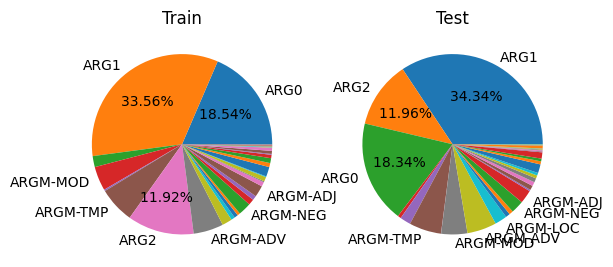

In [183]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.pie(train_values,
        labels = [n if v > sum(train_values) * 0.02 else '' for n, v in zip(train_labels, train_values)],
        autopct=lambda p : '{:.2f}% '.format(p,p * sum(train_values)/100) if p > 10 else '')
plt.title("Train")

plt.subplot(1, 2, 2)
plt.pie(test_values,
        labels = [n if v > sum(test_values) * 0.02 else '' for n, v in zip(test_labels, test_values)],
        autopct=lambda p : '{:.2f}% '.format(p,p * sum(test_values)/100) if p > 10 else '')
plt.title("Test")

plt.show()

FEATURE FUNCTIONS

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm") 

def dep_dist_to_head(input_text, conll_keys):
    '''
    This function calculates the dependency distance from token to head.
    Input: flat python string
    Return: A list of dict with {'token':token, 'dist_to_head':its distance to head}
            If negative, then the token is before the head.
    '''
    doc = nlp(input_text)
    token_full_info = doc.to_json()['tokens']
    dist_to_head = dict()
    token_combination = ''
    combining_tokens = False

    for i in range(len(doc)):
        
        if doc[i].text.strip() not in conll_keys or combining_tokens:
            combining_tokens = True
            token_combination += doc[i].text.strip()
            if token_combination in conll_keys:
                dist_to_head[token_combination] = token_full_info[i]['id']-token_full_info[i]['head']
                token_combination = ''
                combining_tokens = False
        elif doc[i].text.strip() in conll_keys and not combining_tokens:
            dist_to_head[doc[i].text] = token_full_info[i]['id']-token_full_info[i]['head']
            token_combination = ''

    return dist_to_head

def named_entity_recognition(input_text, conll_keys):
    """
    function to return all named entities from an input text.
        :input: flat python string
        :output: list of all named entities present in the input.
    """

    doc = nlp(input_text)
    ents = doc.ents
    NER_map = dict()
    token_combination = ''
    combining_tokens = False
    combined_is_NER = False

    for i in range(len(doc)):
        
        if doc[i].text.strip() not in conll_keys or combining_tokens:
            combining_tokens = True
            token_combination += doc[i].text.strip()
            if doc[i].text in ents:
                combined_is_NER = True
            if token_combination in conll_keys:
                NER_map[token_combination] = combined_is_NER
                token_combination = ''
                combining_tokens = False
                combined_is_NER = False

        elif doc[i].text.strip() in conll_keys and not combining_tokens:
            if doc[i] in ents:
                NER_map[doc[i].text] = True
            else:
                NER_map[doc[i].text] = False
            token_combination = ''

    return NER_map

  
    #return [wordnet.synsets(str(token)) for token in doc if token != '']

def syntactic_head(input_text, conll_keys):
    '''
    This function finds the syntactic head for each word in the input text.
    Input: flat python string
    Return: heads (list): List of dictionaries with {word:head} relation
    '''
    doc = nlp(input_text)
    head_map = dict()
    token_combination = ''
    combining_tokens = False
        #heads.append({token.text: token.head.text})  # Add {word:head} relation to the list
    
    for i in range(len(doc)):
        
        if doc[i].text.strip() not in conll_keys or combining_tokens:
            combining_tokens = True
            token_combination += doc[i].text.strip()
            if token_combination in conll_keys:
                head_map[token_combination] = doc[i].head.text
                token_combination = ''
                combining_tokens = False
        elif doc[i].text.strip() in conll_keys and not combining_tokens:
            head_map[doc[i].text] = doc[i].head.text
            token_combination = ''

    return head_map

def extract_trigram(conll_keys):

    '''
    This function creates bigrams of the given text
    Input: flat python string
    Return: A list of dict with {'token':token, 'bigram': bigram}
    '''
    try:
        trigram_dict = dict()
        trigram_dict[conll_keys[0]] = [f'SOS {conll_keys[0]} {conll_keys[1]}']
        for i in range(1,len(conll_keys)-1):
            trigram_dict[conll_keys[i]] = f'{conll_keys[i-1]} {conll_keys[i]} {conll_keys[i+1]}'
        trigram_dict[conll_keys[-1]] = f'{conll_keys[-2]} {conll_keys[-1]} EOS'

        return trigram_dict
    except:
        print('TRIGRAM ERROR')
        print(conll_keys)
        
def follows_predicate(predicate, conll_keys):
    '''
    This function checks wether a word immediately follows (comes after) the predicate of the sentence
    '''
    bool_map = dict.fromkeys(conll_keys, False)

    #if there is no predicate in the sentence, return all values as False straight away
    if predicate is None:
        return bool_map
    
    for i, word in enumerate(conll_keys):

        if i == 0:
            continue
        elif conll_keys[i-1] == predicate:
            bool_map[word] = True

    return bool_map

def leads_predicate(predicate, conll_keys):
    '''
    This function checks wether a word immediately leads (comes before) the predicate of the sentence
    '''
    bool_map = dict.fromkeys(conll_keys, False)

    #if there is no predicate in the sentence, return all values as False straight away
    #otherwise if the predicate is at the start there cannot be a leading token, so return all as False
    if predicate is None or conll_keys[0] == predicate:
        return bool_map

    for i, word in enumerate(conll_keys):
        if conll_keys[i+1] == predicate:
            bool_map[word] = True
            break
    return bool_map

In [7]:
def create_features(preplist):
    """
    This function creates extra features by dependency parsing, using a preprocessed list.
    """
    sent_with_feature = []
    
    for sentence in preplist:
        # Extract sentence text
        sentence_text = ' '.join(word['form'] for word in sentence)
        conll_keys = [word['form'] for word in sentence]
        predicate = [word['form'] for word in sentence if word['pred'] != '_']
        if len(predicate) == 0:
            predicate = None
        else:
            predicate = predicate[0]

        try: #try processing each sentence and enriching, this only fails for broken data (URL instead of sentence, or single word conll entries)
            dist_to_head_map = dep_dist_to_head(sentence_text, conll_keys)
            NER_map = named_entity_recognition(sentence_text, conll_keys)
            syntactic_head_map = syntactic_head(sentence_text, conll_keys)
            trigram_map = extract_trigram(conll_keys)
            following_predicate_map = follows_predicate(predicate, conll_keys)
            leading_predicate_map = leads_predicate(predicate, conll_keys)
        except:
            continue
        # Add features back to dict
        news_sentence_dict = []
        for word_dict in sentence:
            new_word_dict = copy.deepcopy(word_dict) # Avoid changing the original file
            
            try:
                #add the distance for each word to head
                new_word_dict['dist_to_head'] = dist_to_head_map[word_dict['form']]
                
                #add value for named entity of each word
                new_word_dict['is_named_entity'] = NER_map[word_dict['form']]

                #add syntactic head
                new_word_dict['syntactic_head'] = syntactic_head_map[word_dict['form']]

                #add word trigram
                new_word_dict['trigram'] = trigram_map[word_dict['form']]

                #following the predicate
                new_word_dict['follows_pred'] = following_predicate_map[word_dict['form']]

                #preceeding the predicate
                new_word_dict['preceeds_pred'] = leading_predicate_map[word_dict['form']]

                news_sentence_dict.append(new_word_dict)
                
            except Exception as e:
                print(e)
                continue
                
        sent_with_feature.append(news_sentence_dict)

    return sent_with_feature

## Single classifier

### Extract training features and labels

In [8]:
def extract_feature_and_label(preplist):
    """
    This function extract features and label from extracted feature list of dicts.
    It will flattern list of sentences into list of tokens.
    """
    data = []
    targets = []
    flatlist = [x for xs in preplist for x in xs]
    for dict in flatlist:
        newdict = copy.deepcopy(dict)
        del newdict['ARG'] # Remove gold
        data.append(newdict)
        targets.append(dict['ARG'])

    return data, targets

In [9]:
training_features, gold_labels = extract_feature_and_label(preprocessed_train)

### Create single logreg

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

def create_log_classifier(train_features, train_targets, max_iter):
    logreg = LogisticRegression(max_iter=max_iter)
    vec = DictVectorizer()
    features_vectorized = vec.fit_transform(train_features)
    model = logreg.fit(features_vectorized, train_targets) 
    return model, vec

In [11]:
model_single, vec_single = create_log_classifier(training_features, gold_labels, 100)

/home/arimo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Predict with single logreg

In [12]:
def classify_data(model, vec, features):  
    features = vec.transform(features)
    predictions = model.predict(features)
    return predictions

In [13]:
using_test_set, test_gold = extract_feature_and_label(preprocessed_test)
single_predictions = classify_data(model_single, vec_single, using_test_set)

### Write output

In [14]:
def write_output_file(predictions, training_features, gold_labels, outputfile):
    outfile = open(outputfile, 'w')
    # add headings
    outfile.write('word' + '\t' + 'gold' + '\t' + 'predict' + '\n')
    for i in range(len(predictions)):
        outfile.write(training_features[i]['form'] + '\t' + gold_labels[i] + '\t' + predictions[i] + '\n')
    outfile.close()

In [15]:
outputpath = 'output/singlelogreg.csv'
write_output_file(single_predictions, using_test_set, test_gold, outputpath)

## Double classifier
First classify is_ARG, then classify ARG_type

In [16]:
def extract_is_ARG_feature_and_label(preplist):
    """
    This function extract features and label from preprocessed list
    """
    data = []
    targets = []
    flatlist = [x for xs in preplist for x in xs]
    for dict in flatlist:
        newdict = copy.deepcopy(dict)
        del newdict['ARG'] # Remove gold
        data.append(newdict)
        
        if dict['ARG'] != '_':
            targets.append(True)
        else:
            targets.append(False)

    return data, targets

**Here, we use less feature for step 1 to reduce overfitting.**

In [17]:
def reducing_features(inputfeature):
    """
    This function reduce the amount of feature used. Input is the ready-to-use feature dict.
    """
    newfeature = copy.deepcopy(inputfeature)
    for newdicts in newfeature:
        del newdicts['ID'], newdicts['lemma'], newdicts['feats'], newdicts['dup'], newdicts['misc'], newdicts['deprel']

    return newfeature

In [18]:
training_features_step1, gold_labels_step1 = extract_is_ARG_feature_and_label(preprocessed_train)

In [19]:
reduced_training_features_step1 = reducing_features(training_features_step1)

In [20]:
model_double_1, vec_double_1 = create_log_classifier(reduced_training_features_step1, gold_labels_step1, 100)

using_test_set_1, test_gold_1 = extract_is_ARG_feature_and_label(preprocessed_test)
predictions_1 = classify_data(model_double_1, vec_double_1, using_test_set_1)

/home/arimo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
def extract_ARG_type_feature_and_label(preplist):
    """
    This function extract ARG_type feature from the training set.
    """

    data = []
    targets = []
    flatlist = [x for xs in preplist for x in xs]
    
    for dict in flatlist:
        newdict = copy.deepcopy(dict)
        del newdict['ARG'] # Remove gold
        if dict['ARG'] != '_':
            newdict['is_ARG'] = 'True'
        else:
            newdict['is_ARG'] = 'False'
        
        data.append(newdict)
        targets.append(dict['ARG'])

    return data, targets

In [22]:
training_features_step2, gold_labels_step2 = extract_ARG_type_feature_and_label(preprocessed_train)

In [23]:
def extract_ARG_type_feature_and_label_with_prediction(preplist, predictions_1):
    """
    This function add result from the first classifier to the feature list for the test sets.
    """

    data = []
    targets = []
    flatlist = [x for xs in preplist for x in xs]
    
    for dict, predictions in zip(flatlist, predictions_1):
        newdict = copy.deepcopy(dict)
        del newdict['ARG'] # Remove gold
        newdict['is_ARG'] = str(predictions)
        
        data.append(newdict)
        targets.append(dict['ARG'])

    return data, targets

In [24]:
model_double_2, vec_double_2 = create_log_classifier(training_features_step2, gold_labels_step2, 100)

/home/arimo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
using_test_set_2, test_gold_2 = extract_ARG_type_feature_and_label_with_prediction(preprocessed_test, predictions_1)

predictions_2 = classify_data(model_double_2, vec_double_2, using_test_set_2)

In [26]:
outputpath = 'output/doublelogreg.csv'
write_output_file(predictions_2, using_test_set_2, test_gold_2, outputpath)

## GPU implementation

In [98]:
import cudf
import numpy as np
import cupy as cp
from cuml import LogisticRegression

In [28]:
from sklearn.feature_extraction import DictVectorizer

def dict_vectorize(train_features):
    vec = DictVectorizer()
    features_vectorized = vec.fit_transform(train_features)
    return vec, features_vectorized

In [29]:
def get_mappings_dict(inputlist):
    category_list = copy.deepcopy(inputlist)
    category_list.append(None)
    map_dict = dict(zip(set(category_list), range(len(set(category_list)))))
    map_dict_reverse = {v: k for k, v in map_dict.items()}
    return map_dict, map_dict_reverse

def numerical_mapping(category_list, list_dict):
    numerical_list = [list_dict[line] for line in category_list]
    return numerical_list

mydict, mydict_rev = get_mappings_dict(gold_labels)

In [30]:
def cp_feature_and_gold(feat_vec, gold_labels=gold_labels, dict=mydict):
    # This function convert array to cuml required cp_array type
    cpfeature = cp.sparse.csr_matrix(feat_vec)
    cpgold = [dict[line] for line in gold_labels]
    cpgold = cp.array(cpgold, dtype=cp.int64)
    return cpfeature, cpgold

In [31]:
def classify_data_with_rewrite(using_test_set, vec, model, dict=mydict_rev):  
    features = vec.transform(using_test_set)
    predictions = model.predict(features)
    rw_predictions = [dict[line] for line in predictions]
    return rw_predictions

### Single classifier

In [32]:
vec_single, feat_vec_single = dict_vectorize(training_features)

In [33]:
X_single, y_single = cp_feature_and_gold(feat_vec_single)

In [34]:
reg_single = LogisticRegression(max_iter=50000,class_weight='balanced')
reg_single.fit(X_single,y_single)

LogisticRegression()

In [35]:
using_test_set, test_gold = extract_feature_and_label(preprocessed_test)
single_pred = classify_data_with_rewrite(using_test_set,vec_single,reg_single)

In [36]:
def write_cp_output_file(predictions, training_features, gold_labels, outputfile):
    outfile = open(outputfile, 'w', encoding='utf8')
    # add headings
    outfile.write('word' + '\t' + 'gold' + '\t' + 'predict' + '\n')
    for i in range(len(predictions)):
        outfile.write(training_features[i]['form'] + '\t' + gold_labels[i] + '\t' + predictions[i] + '\n')
    outfile.close()

In [37]:
outputpath = 'output/GPUsinglelogreg.csv'
write_cp_output_file(single_pred, using_test_set, test_gold, outputpath)

### Double classifier

In [38]:
#vec_double_1, feat_vec_double_1 = dict_vectorize(training_features_step1)
vec_double_1, feat_vec_double_1 = dict_vectorize(reduced_training_features_step1)

In [39]:
X_double_1 = cp.sparse.csr_matrix(feat_vec_double_1)
y_double_1 = cp.array(gold_labels_step1)

In [40]:
reg_double_1 = LogisticRegression(max_iter=5000)
reg_double_1.fit(X_double_1,y_double_1)

LogisticRegression()

In [41]:
using_test_set_1, test_gold_1 = extract_is_ARG_feature_and_label(preprocessed_test)
using_test_set_1_vec = vec_double_1.transform(using_test_set_1)

In [42]:
double_pred_1 = reg_double_1.predict(using_test_set_1_vec)

### Quick overfit check

In [43]:
from sklearn.metrics import classification_report
report_double_1 = classification_report(test_gold_1, double_pred_1, digits = 7, target_names = ['True', 'False'])

In [44]:
print(report_double_1)

              precision    recall  f1-score   support

        True  0.9107113 0.9970201 0.9519133     93626
       False  0.4899452 0.0284501 0.0537775      9420

    accuracy                      0.9084778    103046
   macro avg  0.7003282 0.5127351 0.5028454    103046
weighted avg  0.8722468 0.9084778 0.8698098    103046



#### Second classifier

In [45]:
training_features_step2, gold_labels_step2 = extract_ARG_type_feature_and_label(preprocessed_train)

In [46]:
vec_double_2, feat_vec_double_2 = dict_vectorize(training_features_step2)

In [47]:
X_double_2, y_double_2 = cp_feature_and_gold(feat_vec_double_2)

In [48]:
reg_double_2 = LogisticRegression(max_iter=50000,class_weight='balanced')
reg_double_2.fit(X_double_2,y_double_2)

LogisticRegression()

In [49]:
using_test_set_2, test_gold_2 = extract_ARG_type_feature_and_label_with_prediction(preprocessed_test, double_pred_1)

In [50]:
using_test_set, test_gold = extract_feature_and_label(preprocessed_test)
double_pred_2 = classify_data_with_rewrite(using_test_set_2,vec_double_2,reg_double_2)

In [51]:
def write_cp_output_file_2(predictions, double_pred_1, training_features, gold_labels, outputfile):
    outfile = open(outputfile, 'w', encoding='utf8')
    # add headings
    outfile.write('word' + '\t' + 'gold' + '\t' + 'pred1' + '\t' + 'predict' + '\n')
    for i in range(len(predictions)):
        outfile.write(training_features[i]['form'] + '\t' + gold_labels[i] + '\t' + str(double_pred_1[i]) + '\t'+ predictions[i] + '\n')
    outfile.close()

In [52]:
outputpath = 'output/GPUdoublelogreg.csv'
write_cp_output_file_2(double_pred_2, double_pred_1, using_test_set_2, test_gold_2, outputpath)

## Evaluation

### Sklearn - CPU - 100 it

In [53]:
#labels = list(test_gold) + list(gold_labels)
label_set = set(sorted(test_gold))

In [ ]:
report_single_cpu = classification_report(test_gold, single_predictions, digits = 7, target_names = label_set)

report_double_1_cpu = classification_report(test_gold_1, predictions_1, digits = 7, target_names = ['True', 'False'])
report_double_2_cpu = classification_report(test_gold_2, predictions_2, digits = 7, target_names = label_set)

In [97]:
print(report_double_1_cpu)

              precision    recall  f1-score   support

        True  0.9101635 0.9978104 0.9519738     93626
       False  0.4925743 0.0211253 0.0405130      9420

    accuracy                      0.9085263    103046
   macro avg  0.7013689 0.5094679 0.4962434    103046
weighted avg  0.8719894 0.9085263 0.8686522    103046



### cuml - GPU - 50000 it

In [ ]:
report_single_gpu = classification_report(test_gold, single_pred, digits = 7, target_names = label_set)

report_double_1_gpu = classification_report(test_gold_1, double_pred_1, digits = 7, target_names = ['True', 'False'])
report_double_2_gpu = classification_report(test_gold_2, double_pred_2, digits = 7, target_names = label_set)

In [70]:
print(report_single_gpu)

              precision    recall  f1-score   support

         C-V  0.3523810 0.0214120 0.0403710      1728
           _  0.4212329 0.0380216 0.0697477      3235
  C-ARGM-CXN  0.0000000 0.0000000 0.0000000         4
    ARGM-LOC  0.3473684 0.0292813 0.0540098      1127
    ARGM-CXN  1.0000000 0.0135135 0.0266667        74
  C-ARG1-DSP  0.0000000 0.0000000 0.0000000        56
  R-ARGM-ADJ  0.0000000 0.0000000 0.0000000         1
  C-ARGM-LOC  0.0000000 0.0000000 0.0000000         2
    ARGM-TMP  0.4500000 0.0398230 0.0731707       226
        ARG4  0.2727273 0.0120968 0.0231660       496
        ARG5  0.0000000 0.0000000 0.0000000        46
      R-ARG0  0.0000000 0.0000000 0.0000000        13
        ARG1  0.0000000 0.0000000 0.0000000        12
    ARGM-PRD  0.0000000 0.0000000 0.0000000        47
    ARGM-ADJ  0.5625000 0.2472527 0.3435115       182
    ARGM-ADV  1.0000000 0.0666667 0.1250000       105
  R-ARGM-DIR  0.0000000 0.0000000 0.0000000        24
    ARGM-LVB  0.2222222 0.0